# Capstone Project: Predicting  Gross Daily Sales w/ SARIMAX for Budget Customization (In Sample)

## Problem Statement:

I am a consultant hired by restaurant owners from a wine and pizzeria concept, since new management has taken over their costs have gone through the roof and now, they are 25K in the red on average each month. For them to recoup their loss I need to figure out how to properly structure their budgets. I will create a SARIMAX predictive sales model to base my customized budgets from. My metric will be RMSE to gauge my model's performance with because the output will be on the same scale as my data. A successful model will output predictive sales values within a $550.00 range. My model Selection metric will be AIC because of it's ideal use case for smaller data sets such as mine.

## Executive Summary:

Data Procurement; I gathered the data from Touchbistro which is a cloud-based POS (Point of Sale) platform that the company uses. It was exported via 5 separate csv files, that were cleaned then concatenated.The data is from June 1st, 2018 – February 16th, 2020. Quarterly information was only obtained for Q3 & Q4 for 2018 and then all of 2019. Data preproecessing; data was read in as “objects” which then had to be cleaned and converted to their appropriate data types in order to be utilized in my SARIMAX model. SARIMAX models are dependent on a sorted date index with set period frequencies. 

EDA; I looked at the correlation heatmap of daily sales to get a better sense of what were the best predictors and to visualize any features  that should be dropped because they are too correlated. "Margin" and "Net Sales" had to be dropped with a positive correlation of 1 percent. Daily Gross Sales are not normally distributed and skewed with what looks like a mean around $4,000.00. 
Bill Count, Labor Cost, Margin and Net Sales all have similar distributions as Gross Sales which means they are probably highly correlated



While exploring quarterly trends I discovered that Daily Gross Sales were stagnant with a growth on average of 1.1 percent when comparing Year over Year Q3 VS Q4 of 2018 and 2019 data. The most interesting observation I noticed was Q1 to Q2 of 2019 the daily gross sales mean increased by $749.00. The quarterly features distributions for the most part tend to follow the same trend as as above, where they are similar to daily gross sales's and are left skewed. 

These features with similar distributions are also proved to be correlated by visualing the heatmap correaltion graph.Bill count, labor cost and voids tend to have more similar distributions on a quarterly range than on a whole data range. In order to model you must ensure stationarity before modeling. My data has a p-value 0.000280 which gives us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.The ACF and PACF plots showed that the obervations are follow similar trends and are correlated. However ultimately I chose my parameters based on a manual gridsearch of my data. For my model prep I had to split the index manually at the row with 75% of my data for my train set and the other 25% for my test/validation set.Indexes had to be converted to Datetime index with a frequency of “d” in order to be fed into the model. 
My model's RMSE is off by a mean of around 530 which is way better than my baseline model of 1557..

In conclusion I was able to build a model up to my standards however it was an in-sample model. For this to be applied correctly I will have to go back and look at my out of sample model notebook and figure out how to improve it. As it is completly unusable with a RMSE of 1896 which is no good compared to my baseline model. I can still look at my Actual Costs vs Actual Sales and offer budget customizations as I did in the functions above. When I do get my out of sample working I can use the same function above to calcuate the custom budgets.


## Importing Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Import ARIMA model.
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from os import listdir
from os.path import isfile, join

import math

%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import itertools

import warnings
warnings.filterwarnings("ignore")

In [4]:
def data_reader_cleaner(folder_path):
    data_file_csv = [f for f in listdir(folder_path) if isfile(join(folder_path, f)) & f.endswith('.csv')]
    df = pd.DataFrame()
    for file_path in data_file_csv:
        # 1) read in csv
        data = pd.read_csv(folder_path + file_path)
        # 2) reset_index
        data.reset_index(inplace=True)
        # 3)set colunms as row 0 
        data.columns = data.iloc[0]
        # 4) drop first and last columns
        data.drop([0, len(data)-1], axis = 0, inplace = True)
        # 5) set index as date
        data.set_index('Date', inplace = True) 
        # 6) Print out if nulls
        if data.isnull().sum().sum() > 0:
            data.isnull().sum().sort_values(ascending = False)         
        #  ) concats
        df = pd.concat([data,df])
    return df

In [5]:
merge = data_reader_cleaner('../data/')


## Data Preprocessing

In [6]:
t = ["Voids", "Gross Sales", "Discounts", "Net Sales", "Menu Item Cost", "Labor Cost", "Margin"]


In [7]:
merge[t] = merge[t].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [8]:
merge["Bill Count"] = merge["Bill Count"].astype(int)

In [9]:
merge = pd.concat([merge, pd.get_dummies(merge['Day of the Week'])], axis=1)

In [10]:
merge.drop('Day of the Week', axis = 1, inplace = True)

In [11]:
merge.sort_index(inplace = True)

## Exploratory Data Analysis

In [12]:
merge.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,85.394525,138.648164,4563.761675,47.137069,4516.624622,95.339919,1122.660451,3298.624251,0.144928,0.141707,0.144928,0.144928,0.141707,0.140097,0.141707
std,31.350370,260.621064,1733.331732,59.488305,1724.805955,119.316238,285.055250,1533.978078,0.352312,0.349030,0.352312,0.352312,0.349030,0.347367,0.349030
min,21.000000,0.000000,1057.000000,0.000000,1057.000000,0.000000,548.100000,32.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61.000000,54.000000,3217.000000,0.000000,3185.500000,0.000000,909.480000,2159.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,80.000000,110.000000,4203.000000,23.500000,4178.000000,60.000000,1107.280000,3062.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,106.000000,181.000000,5726.000000,70.000000,5646.500000,128.000000,1288.970000,4290.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,211.000000,6123.000000,10946.000000,401.000000,10861.500000,888.000000,2348.010000,8467.980000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualizing Feature Distributions

- Daily Gross Sales are not normally distributed and skewed with what looks like a mean around $4,000.00

Text(0.5, 1.0, 'Merge Daily Gross Sales')

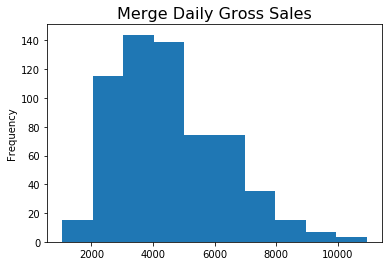

In [13]:
merge["Gross Sales"].plot(kind = "hist")
plt.title(label = 'Merge Daily Gross Sales', fontsize=16)

In [14]:
x_cols = ["Voids", "Discounts", "Net Sales", "Menu Item Cost", "Labor Cost", "Margin", "Bill Count"]    

- Bill Count, Labor Cost, Margin and Net Sales all have similar distributions as Gross Sales which means they are probably highly correlated.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c70cd90>,
      dtype=object)

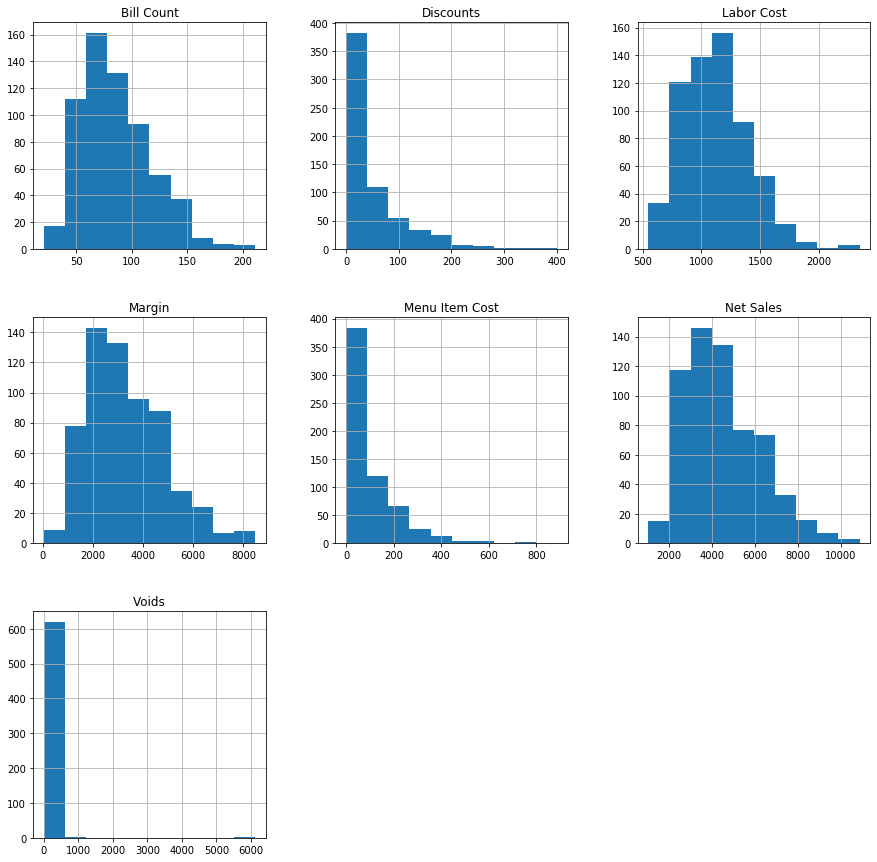

In [15]:
merge[x_cols].hist(figsize=(15, 15))

### Exploring the Financial Quarterly Trends
(Below are observations for the entire quarterly section, no need to scroll.)

- Daily Gross Sales were stagnant with a growth on average of 1.1% when comparing Year over Year Q3 VS Q4 of 2018 and 2019 data.
- The most interesting observation I noticed was Q1 to Q2 of 2019 the daily gross sales mean increased by $749.00.
- The quarterly features distributions for the most part tend to follow the same trend as as above, where they are similar to daily gross sales's and are left skewed.
- These features with similar distributions are also proved to be correlated by visualing the heatmap correaltion graph.
Bill count, labor cost and voids tend to have more similar distributions on a quarterly range than on a whole data range. 


#### Q3 2018 -- July 1, 2018 to September 30, 2018

In [16]:
third_q_2018 = merge[30:122:]

In [17]:
third_q_2018.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,91.673913,146.065217,4718.968261,41.383043,4677.585217,7.956522,1081.670543,3587.958152,0.141304,0.141304,0.141304,0.152174,0.141304,0.141304,0.141304
std,28.647194,85.592673,1487.193970,50.105473,1485.076127,26.041350,239.955602,1350.993801,0.350244,0.350244,0.350244,0.361158,0.350244,0.350244,0.350244
min,41.000000,12.000000,2457.000000,0.000000,2457.000000,0.000000,674.000000,1042.870000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.750000,81.000000,3419.757500,0.000000,3415.757500,0.000000,905.157500,2558.672500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88.000000,134.000000,4581.000000,20.000000,4538.000000,0.000000,1041.255000,3471.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,111.000000,205.250000,5912.000000,66.250000,5872.437500,0.000000,1200.527500,4660.465000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,192.000000,386.000000,9567.000000,213.250000,9567.000000,144.000000,1870.660000,7696.340000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Q3 2019 Daily Gross Sales')

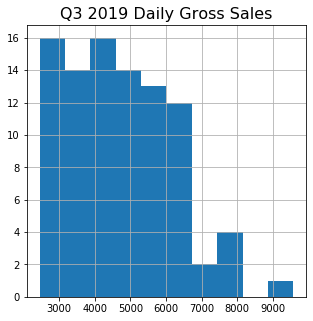

In [18]:
third_q_2018["Gross Sales"].hist(figsize=(5, 5))
plt.title(label = 'Q3 2019 Daily Gross Sales', fontsize=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d160b90>,
      dtype=object)

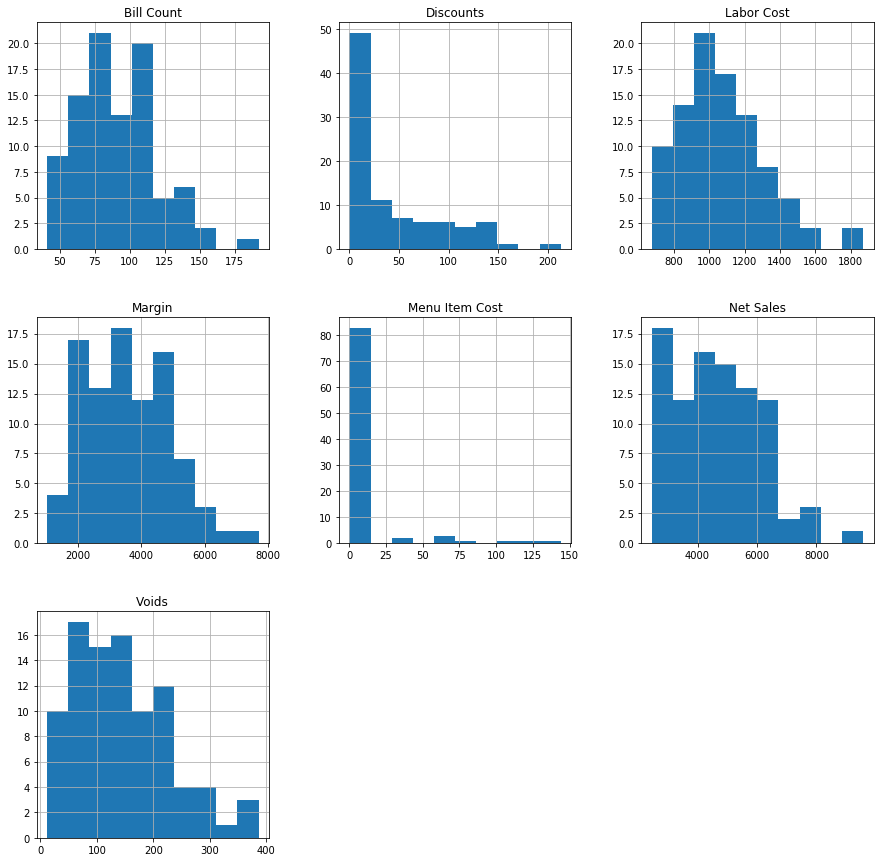

In [19]:
third_q_2018[x_cols].hist(figsize=(15, 15))


In [20]:
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    plt.figure(figsize=(10, 10))
    graph = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    plt.title(label = 'Correlation Heatmap of Daily Gross Sales ', fontsize=16)
    return graph

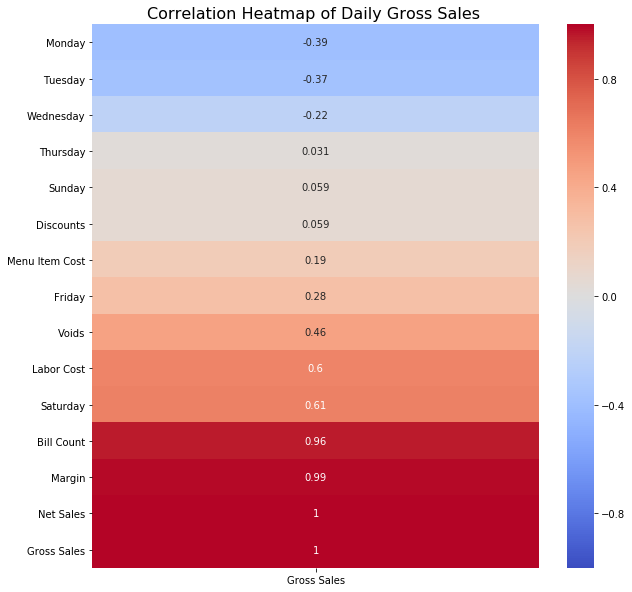

In [21]:
heatmap_numeric_w_dependent_variable(third_q_2018, "Gross Sales")

#### Q4 2018 -- October 1, 2018 to December 31, 2018

In [22]:
fourth_q_2018 = merge[122:212:]

Text(0.5, 1.0, 'Q4 2018 Daily Gross Sales')

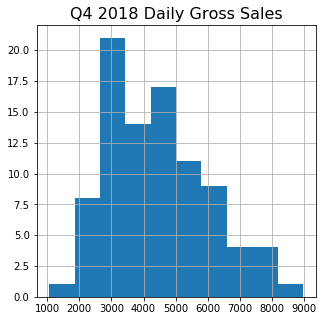

In [23]:
fourth_q_2018["Gross Sales"].hist(figsize=(5, 5))
plt.title(label = 'Q4 2018 Daily Gross Sales', fontsize=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136bde810>,
      dtype=object)

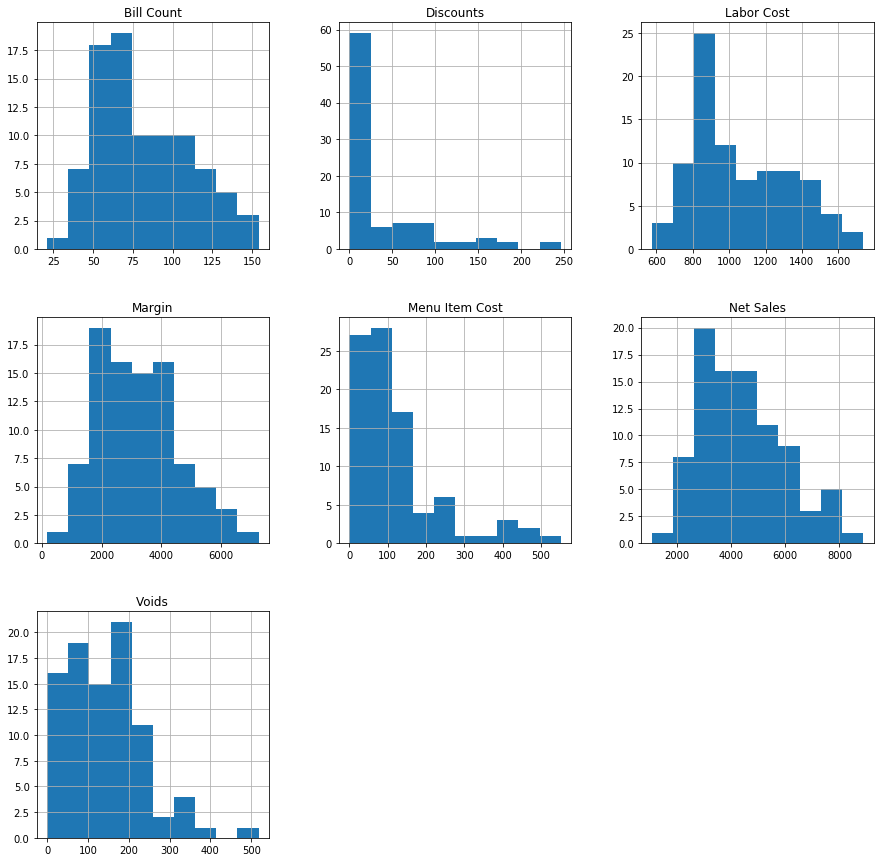

In [24]:
fourth_q_2018[x_cols].hist(figsize=(15, 15))

In [25]:
fourth_q_2018.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,81.933333,144.733333,4440.583778,37.634000,4402.949778,121.633333,1058.745889,3222.570556,0.144444,0.144444,0.144444,0.144444,0.144444,0.133333,0.144444
std,30.066892,93.333497,1600.987767,57.149962,1590.831351,115.510246,270.381395,1367.933870,0.353509,0.353509,0.353509,0.353509,0.353509,0.341839,0.353509
min,21.000000,0.000000,1068.000000,0.000000,1068.000000,0.000000,573.790000,173.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.250000,78.250000,3099.507500,0.000000,3041.000000,48.000000,842.072500,2184.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75.000000,136.000000,4286.000000,10.050000,4223.750000,96.000000,993.800000,3084.485000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,103.750000,192.250000,5387.000000,56.000000,5369.425000,139.500000,1268.100000,3992.682500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,154.000000,518.000000,8954.010000,246.000000,8869.510000,552.000000,1736.280000,7247.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


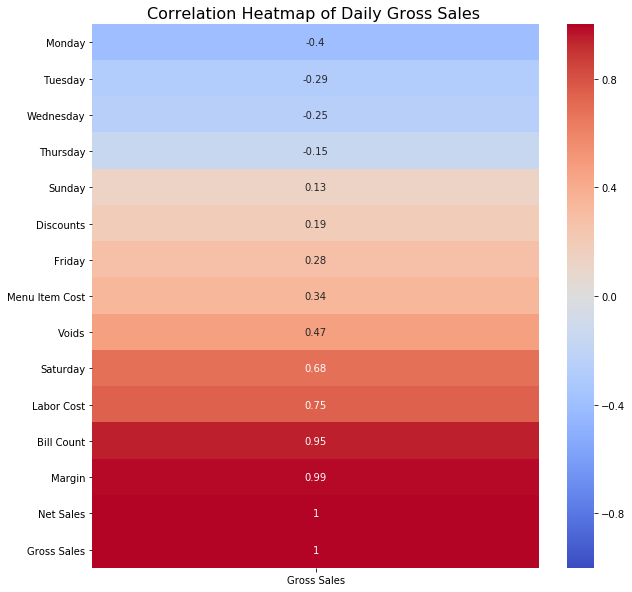

In [26]:
heatmap_numeric_w_dependent_variable(fourth_q_2018, "Gross Sales")

#### Q1 2019 -- January 1, 2019 to March 31, 2019

In [27]:
first_q_2019 = merge[213:302:]

In [28]:
first_q_2019.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,77.011236,81.415843,4099.816180,50.739438,4049.076742,132.911124,1044.136067,2872.029551,0.146067,0.134831,0.146067,0.134831,0.146067,0.146067,0.146067
std,34.268159,73.039091,1941.617473,69.163225,1915.557537,126.664166,274.400774,1690.107864,0.355175,0.343479,0.355175,0.343479,0.355175,0.355175,0.355175
min,26.000000,0.000000,1478.000000,0.000000,1341.500000,0.000000,588.870000,504.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,23.000000,2623.000000,0.000000,2623.000000,36.000000,825.000000,1632.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,68.000000,3544.000000,21.000000,3542.450000,96.000000,1007.450000,2346.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,99.000000,121.000000,5334.000000,80.000000,5227.000000,198.650000,1202.600000,4021.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,320.000000,9887.000000,344.500000,9707.500000,750.000000,1778.150000,8290.510000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Q1 2019 Daily Gross Sales')

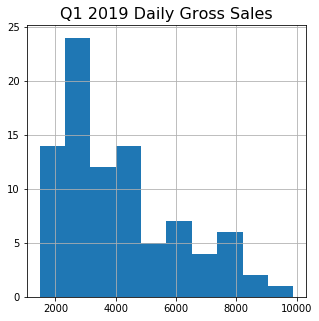

In [29]:
first_q_2019["Gross Sales"].hist(figsize=(5, 5))
plt.title(label = 'Q1 2019 Daily Gross Sales', fontsize=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139917c90>,
      dtype=object)

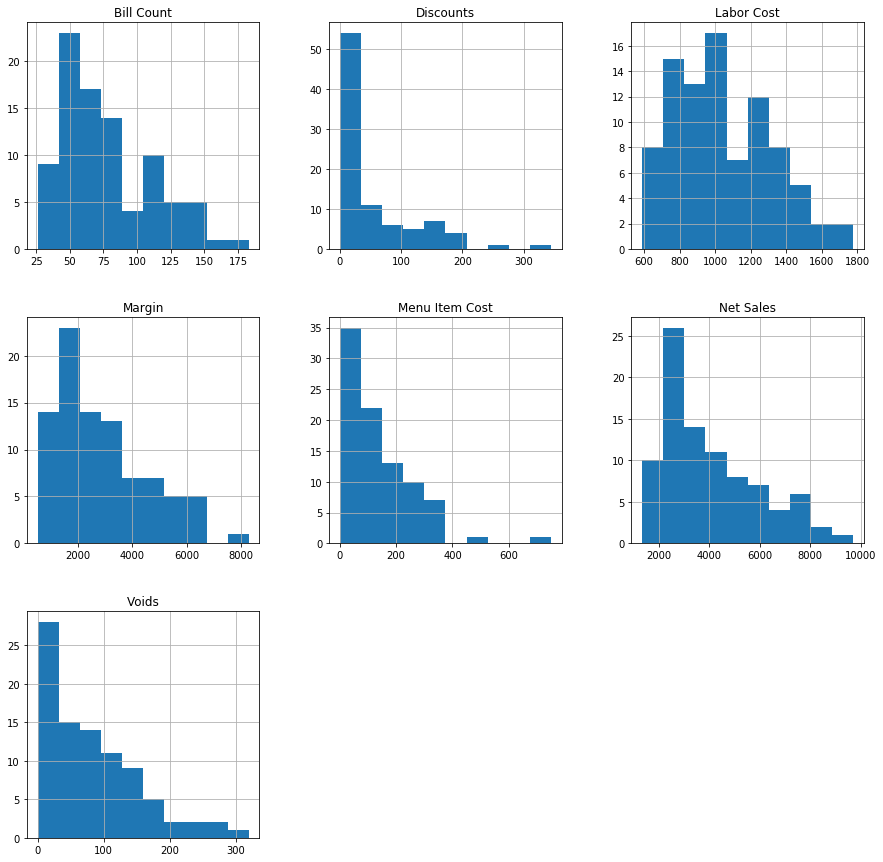

In [30]:
first_q_2019[x_cols].hist(figsize=(15, 15))

Text(0.5, 1, 'Correlation Heatmap of Daily Gross Sales Q1 2019 ')

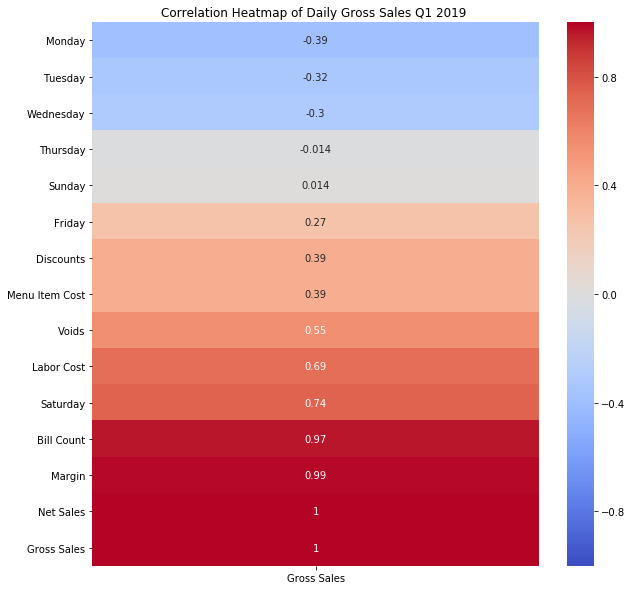

In [31]:
heatmap_numeric_w_dependent_variable(first_q_2019, "Gross Sales")
plt.title(label = 'Correlation Heatmap of Daily Gross Sales Q1 2019 ')

#### Q2 2019 -- April 1, 2019 to June 30, 2019

In [32]:
second_q_2019 = merge[303:394:]

In [33]:
second_q_2019.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,90.021978,146.552637,4849.107253,86.032527,4763.074725,141.406593,1084.142088,3537.526044,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
std,34.418980,113.184222,1856.418381,82.334550,1846.820106,155.656172,326.406251,1566.872155,0.351866,0.351866,0.351866,0.351866,0.351866,0.351866,0.351866
min,40.000000,0.000000,1798.000000,0.000000,1798.000000,0.000000,548.100000,1225.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.000000,63.000000,3473.500000,24.500000,3340.250000,48.000000,839.110000,2471.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,85.000000,122.000000,4426.810000,55.350000,4426.810000,96.000000,1060.310000,3128.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,113.000000,201.000000,6046.625000,134.250000,5966.145000,188.000000,1260.675000,4478.135000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,211.000000,596.000000,10946.000000,401.000000,10861.500000,888.000000,1992.760000,8467.980000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Q2 2019 Daily Gross Sales')

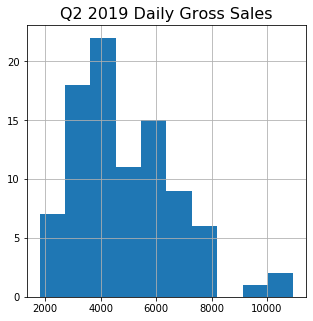

In [34]:
second_q_2019["Gross Sales"].hist(figsize=(5, 5))
plt.title(label = 'Q2 2019 Daily Gross Sales', fontsize=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a5f7190>,
      dtype=object)

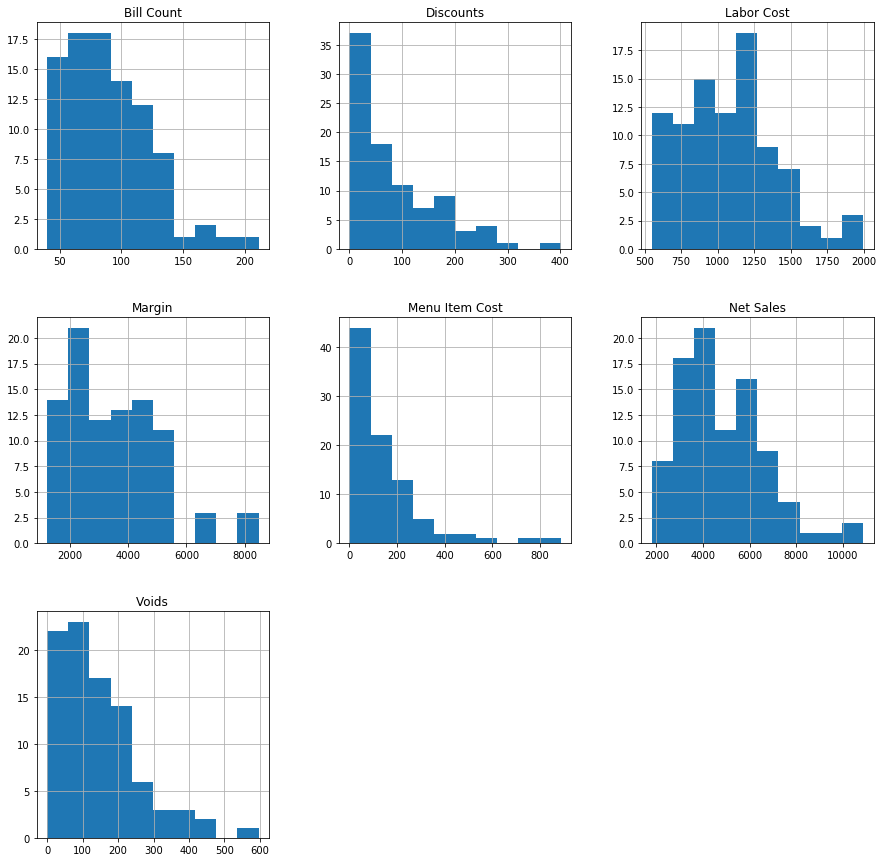

In [35]:
second_q_2019[x_cols].hist(figsize=(15, 15))

Text(0.5, 1, 'Correlation Heatmap of Daily Gross Sales Q2 2019 ')

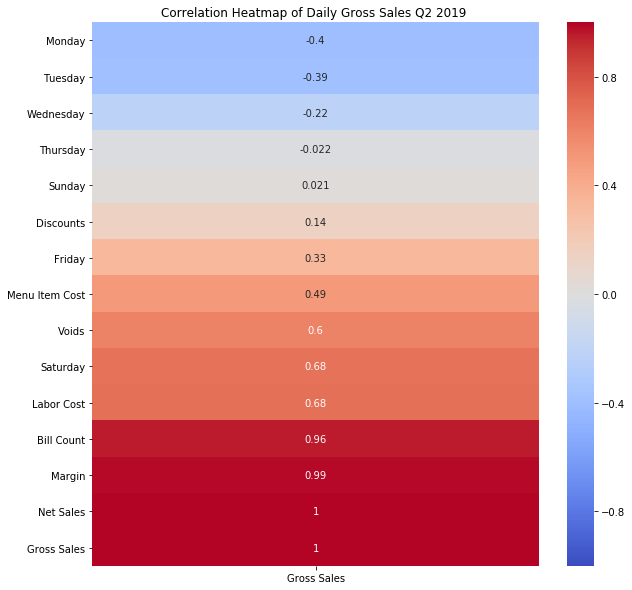

In [36]:
heatmap_numeric_w_dependent_variable(second_q_2019, "Gross Sales")
plt.title(label = 'Correlation Heatmap of Daily Gross Sales Q2 2019 ')

#### Q3 2019 -- July 1, 2019 to September 30, 2019

In [37]:
third_q_2019 = merge[394:486:]

In [38]:
third_q_2019.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,83.434783,133.181304,4378.946848,57.735326,4321.211630,102.695652,1178.853913,3039.662065,0.141304,0.152174,0.141304,0.141304,0.141304,0.141304,0.141304
std,25.943431,88.517944,1424.607532,51.325948,1422.973153,101.595810,240.431315,1273.235361,0.350244,0.361158,0.350244,0.350244,0.350244,0.350244,0.350244
min,33.000000,0.000000,1537.000000,0.000000,1490.250000,0.000000,688.600000,394.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.250000,63.875000,3474.125000,20.312500,3388.250000,36.000000,1022.967500,2273.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,78.500000,114.000000,4139.665000,44.750000,4060.650000,70.000000,1151.285000,2882.055000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,96.500000,190.500000,5198.875000,77.375000,5133.925000,146.500000,1343.625000,3740.257500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,156.000000,347.000000,8751.500000,234.000000,8688.000000,598.000000,1819.920000,6997.690000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Q3 2019 Daily Gross Sales')

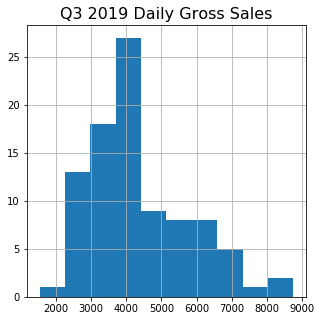

In [39]:
third_q_2019["Gross Sales"].hist(figsize=(5, 5))
plt.title(label = 'Q3 2019 Daily Gross Sales', fontsize=16)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a5ff410>,
      dtype=object)

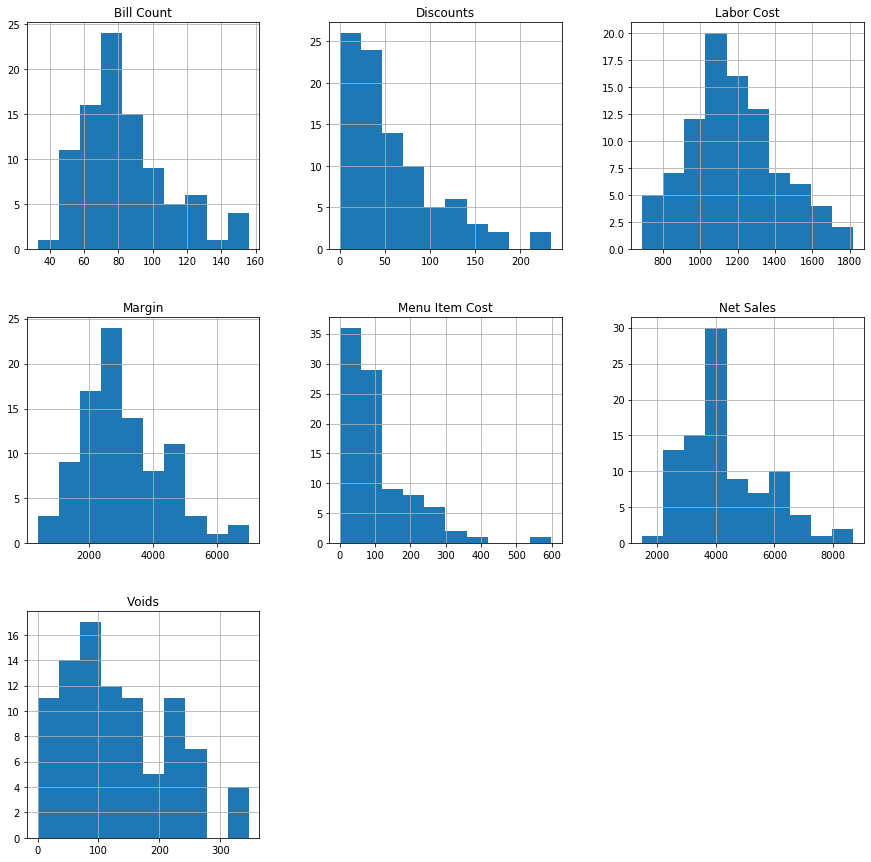

In [40]:
third_q_2019[x_cols].hist( figsize=(15, 15))

Text(0.5, 1, 'Correlation Heatmap of Daily Gross Sales Q3 2019 ')

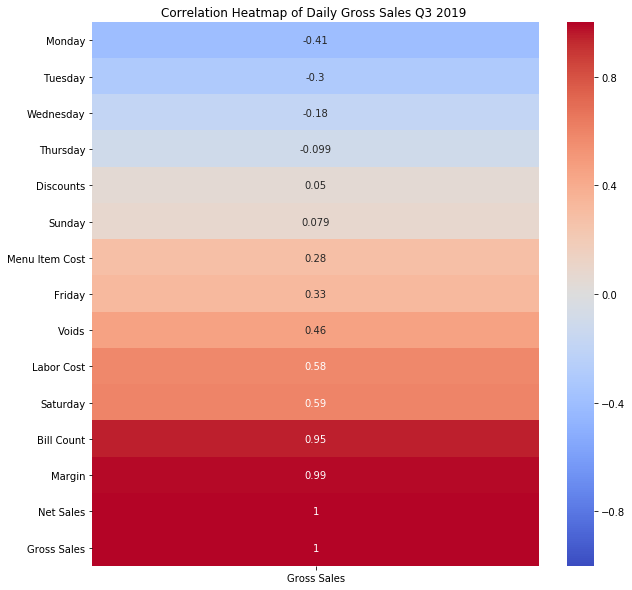

In [41]:
heatmap_numeric_w_dependent_variable(third_q_2019, "Gross Sales")
plt.title(label = 'Correlation Heatmap of Daily Gross Sales Q3 2019 ')

#### Q4 2019 -- October 1, 2019 to December 31, 2019

In [42]:
fourth_q_2019 = merge[486:574:]

In [43]:
fourth_q_2019.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,80.693182,209.128750,4527.290795,24.400000,4502.890795,92.272727,1185.214205,3225.403864,0.147727,0.136364,0.147727,0.147727,0.136364,0.147727,0.136364
std,31.768689,652.173076,1834.534033,27.269334,1831.460135,113.970023,238.125966,1688.765198,0.356863,0.345141,0.356863,0.356863,0.345141,0.356863,0.345141
min,22.000000,0.000000,1057.000000,0.000000,1057.000000,0.000000,556.130000,32.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,54.500000,3131.000000,2.625000,3077.500000,12.000000,1022.922500,1949.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74.000000,114.000000,4084.335000,15.500000,4068.835000,54.000000,1183.780000,2937.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,96.250000,180.250000,5529.500000,33.275000,5506.250000,131.000000,1337.265000,4281.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,175.000000,6123.000000,9298.000000,124.000000,9255.500000,618.000000,1726.390000,7917.760000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Q4 2019 Daily Gross Sales')

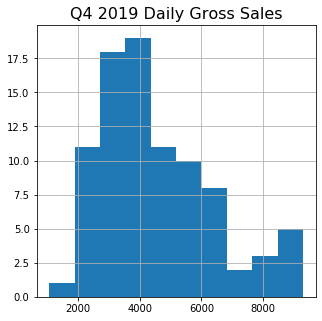

In [44]:
fourth_q_2019["Gross Sales"].hist(figsize=(5, 5))

plt.title(label = 'Q4 2019 Daily Gross Sales', fontsize=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13bab7d90>,
      dtype=object)

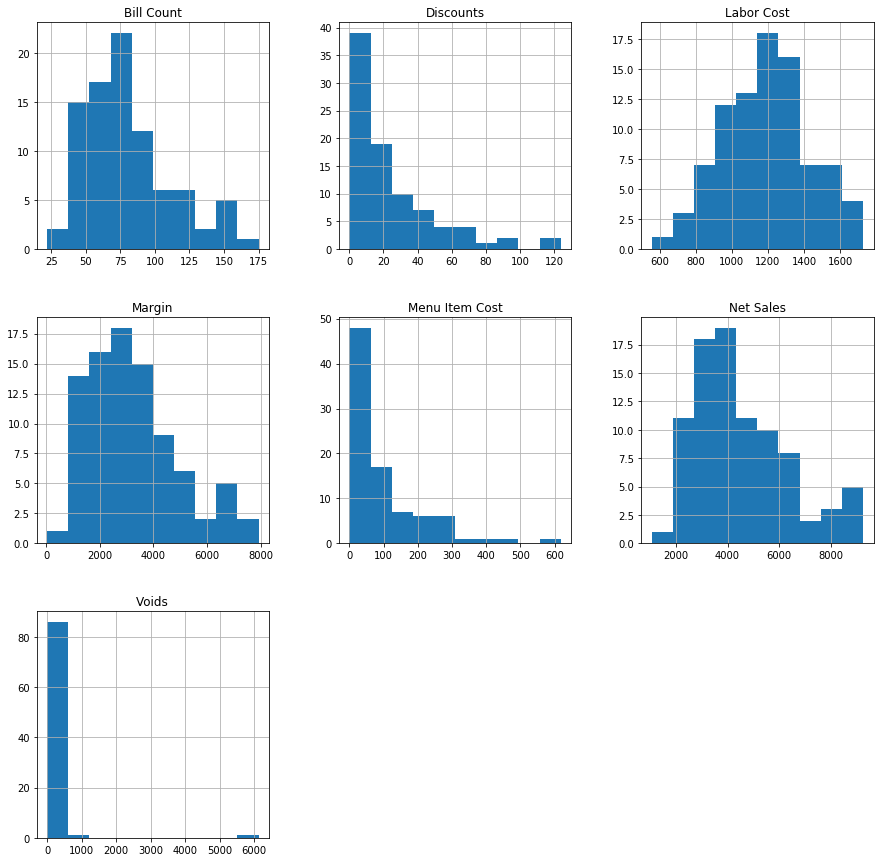

In [45]:
fourth_q_2019[x_cols].hist(figsize=(15, 15))

Text(0.5, 1, 'Correlation Heatmap of Daily Gross Sales Q4 2019 ')

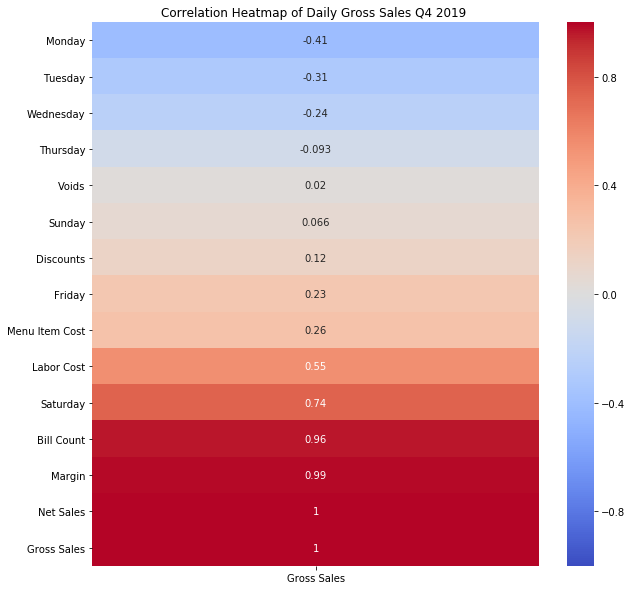

In [46]:
heatmap_numeric_w_dependent_variable(fourth_q_2019, "Gross Sales")
plt.title(label = 'Correlation Heatmap of Daily Gross Sales Q4 2019 ')

### Exploring Year Over Year (YOY) Stats

#####  Q3 2019 Stats VS Q3 2018 Stats 

In [47]:
third_q_2019.describe() - third_q_2018.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
mean,-8.239130,-12.883913,-340.021413,16.352283,-356.373587,94.739130,97.183370,-548.296087,0.0,0.010870,0.0,-0.010870,0.0,0.0,0.0
std,-2.703763,2.925272,-62.586438,1.220476,-62.102974,75.554459,0.475713,-77.758440,0.0,0.010914,0.0,-0.010914,0.0,0.0,0.0
min,-8.000000,-12.000000,-920.000000,0.000000,-966.750000,0.000000,14.600000,-648.790000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
25%,-3.500000,-17.125000,54.367500,20.312500,-27.507500,36.000000,117.810000,-285.062500,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
50%,-9.500000,-20.000000,-441.335000,24.750000,-477.350000,70.000000,110.030000,-589.625000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
75%,-14.500000,-14.750000,-713.125000,11.125000,-738.512500,146.500000,143.097500,-920.207500,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
max,-36.000000,-39.000000,-815.500000,20.750000,-879.000000,454.000000,-50.740000,-698.650000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


##### Q4 2019 Stats VS Q4 2018 Stats 

In [48]:
fourth_q_2019.describe() - fourth_q_2018.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
mean,-1.240152,64.395417,86.707018,-13.234000,99.941018,-29.360606,126.468316,2.833308,0.003283,-0.008081,0.003283,0.003283,-0.008081,0.014394,-0.008081
std,1.701797,558.839579,233.546266,-29.880628,240.628783,-1.540223,-32.255429,320.831328,0.003354,-0.008368,0.003354,0.003354,-0.008368,0.015024,-0.008368
min,1.000000,0.000000,-11.000000,0.000000,-11.000000,0.000000,-17.660000,-140.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.250000,-23.750000,31.492500,2.625000,36.500000,-36.000000,180.850000,-235.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.000000,-22.000000,-201.665000,5.450000,-154.915000,-42.000000,189.980000,-147.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-7.500000,-12.000000,142.500000,-22.725000,136.825000,-8.500000,69.165000,288.927500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,21.000000,5605.000000,343.990000,-122.000000,385.990000,66.000000,-9.890000,670.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Q2 2019 Stats VS Q1 2019 Stats 

In [49]:
second_q_2019.describe() - first_q_2019.describe()

,Bill Count,Voids,Gross Sales,Discounts,Net Sales,Menu Item Cost,Labor Cost,Margin,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,13.010742,65.136795,749.291073,35.293089,713.997984,8.495470,40.006020,665.496493,-0.003210,0.008026,-0.003210,0.008026,-0.003210,-0.003210,-0.003210
std,0.150821,40.145131,-85.199092,13.171325,-68.737431,28.992006,52.005477,-123.235709,-0.003309,0.008387,-0.003309,0.008387,-0.003309,-0.003309,-0.003309
min,14.000000,0.000000,320.000000,0.000000,456.500000,0.000000,-40.770000,721.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,40.000000,850.500000,24.500000,717.250000,12.000000,14.110000,839.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,54.000000,882.810000,34.350000,884.360000,0.000000,52.860000,782.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,80.000000,712.625000,54.250000,739.145000,-10.650000,58.075000,457.075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,28.000000,276.000000,1059.000000,56.500000,1154.000000,138.000000,214.610000,177.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Daily Gross Sales Correlation Heatmap 
- As expected, the bill count is highly correlated. 
- This is probably because they have a high turn over rate and low bill average. An area that could be improved.
- Saturdays are the highest grossing days, typically that is Friday, so the brunch seems to boost the sales quite a bit. 
- They might consider opening earlier than 3PM on weekdays to capture the lunch crowd.
- Menu Item costs should be more correlated which means they probably are not utilizing this feature correctly. 
- Discounts and voids should not carry the same correlation. This means they are probably using them interchangeably which is a major issue.

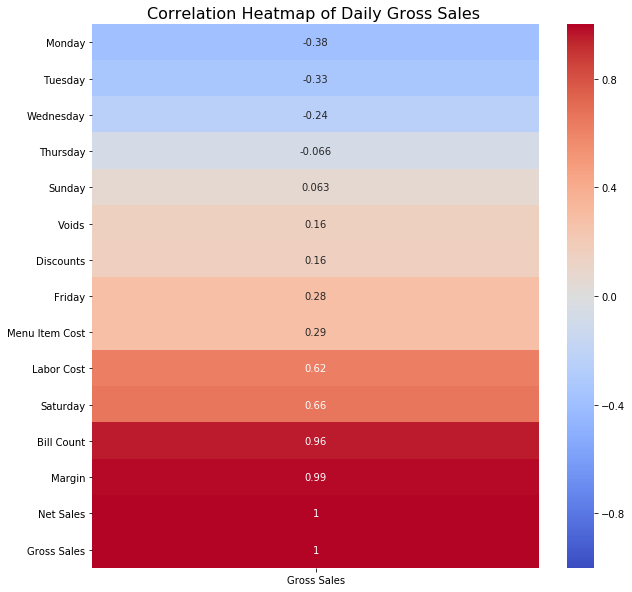

In [50]:
heatmap_numeric_w_dependent_variable(merge, "Gross Sales")

In [51]:
drop_corr_cols = ["Net Sales", "Margin"]

In [52]:
merge.drop(drop_corr_cols, axis = 1, inplace = True)

### Daily Gross Sales (in thousands)
- Visually there does seem to be stationary with a mean somewhere between 4500 - 5000 and some definite trends in the data. I am guessing the trends are based on the upswing of sales towards the end of the week.

In [53]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

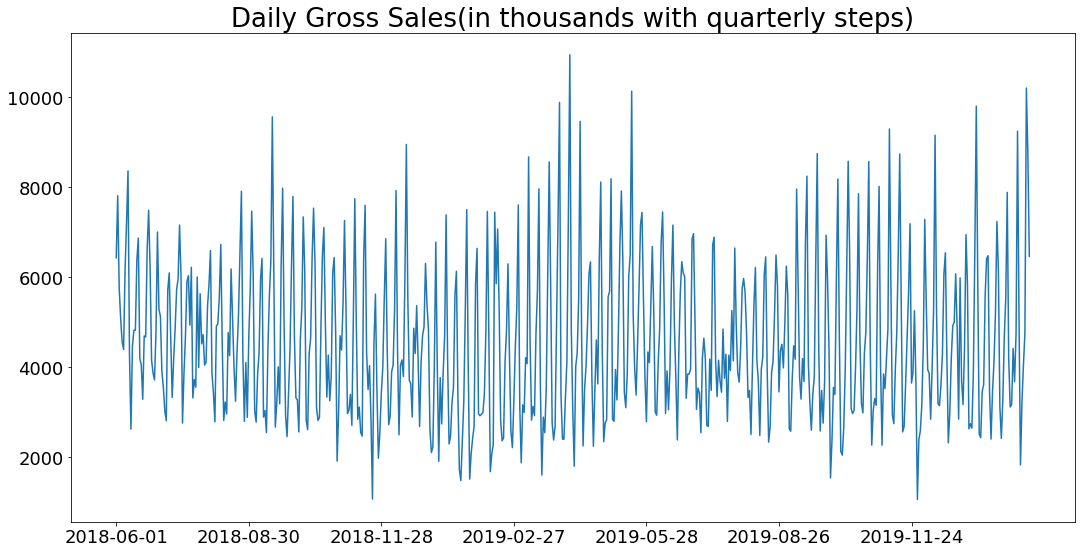

In [54]:
plot_series(merge, ['Gross Sales'], title = "Daily Gross Sales(in thousands with quarterly steps)", steps=90)

## ADF Test for Stationarity
- 1st step choose Parameter d/D
- P-value level of significance is .05
- Must ensure stationarity before modeling
- My data has a p-value 0.000280 which gives us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.
- Parameter d could change after running my manual grid search.

In [55]:
# Run ADF test on original (non-differenced!) data.
adfuller(merge['Gross Sales'])

(-4.413893331869135,
 0.00028047084978728866,
 14,
 606,
 {'1%': -3.4411869900487906,
  '5%': -2.866321181236609,
  '10%': -2.569316262893616},
 9994.277564875969)

In [56]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [57]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(merge['Gross Sales']))

Test Statistic   -4.413893
p-value           0.000280
dtype: float64

## ACF Plot

- 2nd step choose Parameter p/P
- The autocorrelation plot below shows that the observations are highly correlated with one another.
- Observations outside the blue band mean that there is a significant correlation between  Yt and 𝑌𝑡−𝑘 for lag 𝑘
- The autoregressive piece to the ARIMA model is responsible for modeling the long-term trends in our time series.
- you can tell is follow a trend based in the postive and negative staggering outside of the blue window.

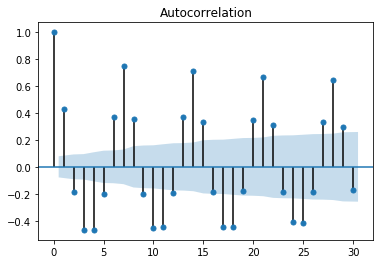

In [58]:
# Generate plot.
plot_acf(merge['Gross Sales'].dropna(), lags=30);

## PACF Plot


- The partial autocorrelation plot checks for the correlation between observations, conditioning on all lower-lag autocorrelations
- Observations outside the blue band mean that there is a significant correlation between 𝑌𝑡 and 𝑌𝑡−𝑘for lag 𝑘, accounting for all lower-order lags.
- The moving average piece to the ARIMA model is responsible for modeling the short-term trends in our time series
- you can tell is follow a trend based in the postive and negative staggering outside of the blue window.


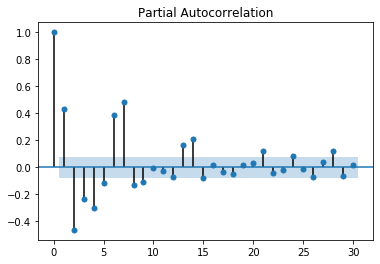

In [59]:
plot_pacf(merge['Gross Sales'].dropna(), lags=30);

## Model Prep
I had to split the index manually at the row with 75% of my data for my train set and the other 25% for my test/validation set.
Indexes had to be converted to Datetime index with a frequency of “d” in order to be fed into the model.

In [60]:
merge.index = pd.DatetimeIndex(merge.index).to_period('d')

In [61]:
X_test_exog = merge.iloc[404:] 

In [62]:
X_train_exog = merge.iloc[:404:]

In [63]:
X_train = X_train_exog.drop("Gross Sales", axis = 1)

In [64]:
X_test = X_test_exog.drop("Gross Sales", axis = 1)

In [65]:
y_train = X_train_exog['Gross Sales']

In [66]:
y_test = X_test_exog['Gross Sales']

## Model Selection with AIC: 

I chose AIC because it is typically used for smaller sample sizes over BIC.
AIC is for model to model comparison; the selection is based on the smallest AIC  value.
I ran a manual grid search to find the best parameters for my model then hardcoded them into my model. 


These are my best params from my best AIC score :


**SARIMAX(1, 1, 1)x(1, 1, 1, 12)12 - AIC:6637.091345311467**


In [67]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]      

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

## Modeling

In [69]:
sarima = SARIMAX(endog = y_train,# inout the best params for this model
                 order = (1, 1, 1),              # (p, d, q)
                 seasonal_order = (1, 1, 1, 12),  # (P, D, Q, S)
                 exog = X_train)
# Fit SARIMA model
model = sarima.fit()

In [70]:
preds = model.predict(start = len(y_train), end = len(y_train) + len(y_test) - 1, exog = X_test)

- Prepping index for graphing

In [71]:
y_test.index = y_test.index.to_timestamp()

In [72]:
y_train.index = y_train.index.to_timestamp()

In [73]:
preds.index = preds.index.to_timestamp()

## Model Evaluation In Sample

- Overall I am quite satisfied with my model, it passed my desired RMSE score and threshold and the residuals plots are satisfactory.

### Baseline Model

For regression problems the baseline model will blindly always predict the mean of the target variable, this being the mean of daily gross sales $4563.76.

In [74]:
base_line = merge["Gross Sales"].mean()

In [75]:
base_line = np.array([base_line for row in y_test])

In [76]:
base_line = pd.Series(base_line)

In [77]:
base_line

0      4563.761675
1      4563.761675
2      4563.761675
3      4563.761675
4      4563.761675
          ...     
212    4563.761675
213    4563.761675
214    4563.761675
215    4563.761675
216    4563.761675
Length: 217, dtype: float64

### Baseline RMSE  Score


RMSE can be interpreted as the standard deviation of the unexplained variance, Lower values of RMSE indicate better fit. 

My model’s average error of daily sales are off by a mean of around $ 1751.61

relative to my baseline model's prediction of $ 4563.76. Therefore any model with a RMSE less than 

751.61 is better than my baseline model.

In [78]:
base_mse = mean_squared_error((y_test), base_line)
base_mse

3068150.528580094

In [79]:
print(f'BASELINE MODEL RMSE SCORE {math.sqrt(base_mse)}')

BASELINE MODEL RMSE SCORE 1751.6136927359566


### Predictive Model Baseline RMSE  Score

- Root Mean Squared Error Score: 530.32 tells you how concentrated the data is around the line of best fit. 
- My model’s average error of daily sales predications is off by a mean of around $530.32
which is way better than my baseline model at 1751.61.

In [80]:
mse = mean_squared_error((y_test), preds)
mse

281239.9680909165

In [81]:
print(f'ACTUAL MODEL RMSE SCORE {math.sqrt(mse)}')

ACTUAL MODEL RMSE SCORE 530.32062763098


### Visualizing Residuals

#### Residual Plot

- You can see that the residuals are homoscedastic and bound around +/- 500 since this is on the same scale as my data and my model is predicting daily sales within my desired threshold.


Text(0.5, 1.0, 'Residual Plot')

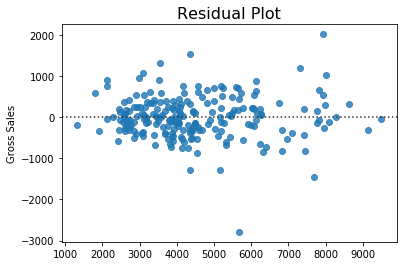

In [82]:
sns.residplot(preds, y_test)
plt.title(label = 'Residual Plot', fontsize=16)

#### Residual Plot with time index


- The nans are from days where the restaurant was closed due to renovations.

In [83]:
residuals = y_test - preds

In [84]:
residuals.dropna(inplace = True)

- The Preds seems to be overprediciting/ underpredicitng quite a bit especailly towards the end of 2019 and start of 2020. It seems some outliers have had quite an affect on my model and should probably be removed. 

Text(0.5, 1.0, 'Residual Plot')

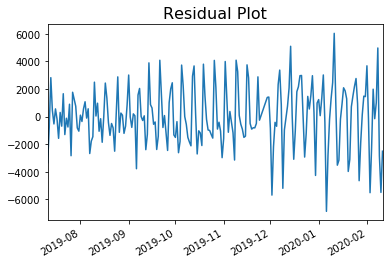

In [85]:
residuals.plot()
plt.title(label = 'Residual Plot', fontsize=16)

#### Residual Histogram 

- The histogram looks normally distrubuted around a mean of 0.

Text(0.5, 1.0, 'Residuals Histogram')

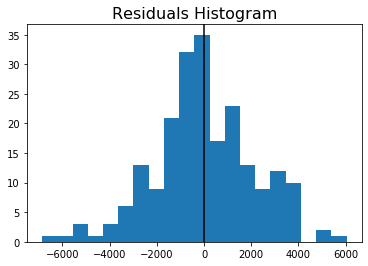

In [86]:
plt.hist(residuals, bins = 20)
plt.axvline(0, color= 'black');
plt.title(label = 'Residuals Histogram', fontsize=16)


### Daily Gross Sales Predictions SARIMAX Graph

- Follows the same trends as previous data you can see how it follow a similar spike pattern.
- Exogenous variables are used for the in-sample predictions which make my  model smarter.
- This explains why it was my scores are so good.


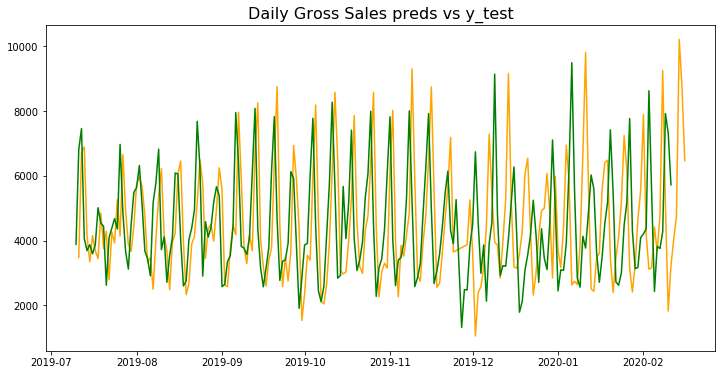

In [87]:
plt.figure(figsize=(12,6))

plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
# plt.plot(future_forecast, color = 'black')

plt.title(label = 'Daily Gross Sales preds vs y_test', fontsize=16)

plt.show();

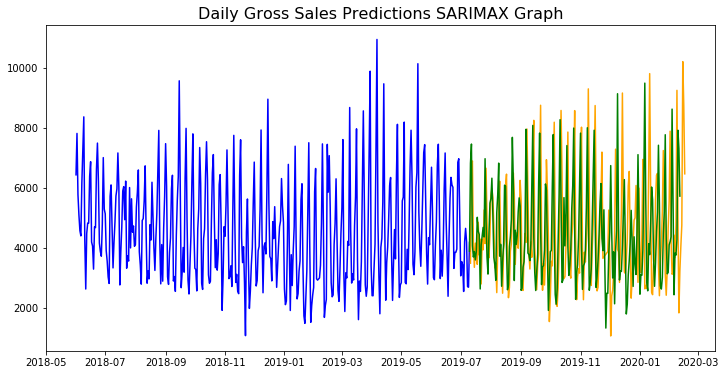

In [88]:
plt.figure(figsize=(12,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
# plt.plot(future_forecast, color = 'black')

plt.title(label = 'Daily Gross Sales Predictions SARIMAX Graph', fontsize=16)

plt.show();

## Budget Calculations

### The Bible:

● Total prime less than 60%

● Food cost 25 to 30%

● Labor cost BOH 15% to 20%

● Labor cost FOH 10 to 15%

● Profitmax15%

● 7 extreme low. 12% average 15 is excellent 

In [89]:
weekly_preds_sales_total = []
for i in range(0, len(preds), 7):
    chunk = preds[i:i + 7]
    weekly_preds_sales_total.append(chunk.sum())

In [ ]:
for i, total in enumerate(weekly_preds_sales_total, start=1):
    print(f'Week {i}: Predicted Sales: ${round(total)}') 
    
    print(f'Total Prime Cost Less Than: ${round(total*.6,2)}')
    
    print(f'Food Cost Guidelines: Low = ${round(total*.25,2)} to High = ${round(total*.30,2)}')
    
    print(f'Labor Cost BOH Guidelines: Low = ${round(total*.15,2)} to High = ${round(total*.20,2)} ')
    
    print(f'Labor Cost FOH Guidelines: Low = ${round(total*.1,2)} to High = ${round(total*.15,2)}')
    
    print(f'Total Profit Guidelines: Low = ${round(total*.07,2)}, Average = ${round(total*.12,2)} & Excellent = ${round(total*.15,2)}')
    
    print()

In [91]:
weekly_actual_sales_total = []
for i in range(0, len(y_test), 7):
    chunk = y_test[i:i + 7]
    weekly_actual_sales_total.append(chunk.sum())

In [ ]:
for i, total in enumerate(weekly_actual_sales_total, start=1):

    print(f'Week {i}: Actual Sales: ${round(total)}')
    
    print(f'Total Prime Cost Less Than: ${round(total*.6,2)}')

    print(f'Food Cost Guidelines: Low = ${round(total*.25,2)} to High = ${round(total*.30,2)}')

    print(f'Labor Cost BOH Guidelines: Low = ${round(total*.15,2)} to High = ${round(total*.20,2)} ')

    print(f'Labor Cost FOH Guidelines: Low = ${round(total*.1,2)} to High = ${round(total*.15,2)}')

    print(f'Total Profit Guidelines: Low = ${round(total*.07,2)}, Average = ${round(total*.12,2)} & Excellent = ${round(total*.15,2)}')
    
    print()

## Conclusion 
I was able to build a model up to my standards however it was an in-sample model. For this to be applied correctly I will have to go back and look at my out of sample model notebook  and figure out how to improve it. As it is completly unusable with a RMSE of 1896. which is no good. I can still look at my Actual Costs vs Actual Sales and offer budget customizations as I did in the functions above. When I do get my out of sample working I can use the same function above to calcuate the custom budgets.

## Immediate Budget Recommendations
Total Prime costs are on average 20% over the suggested budget.
The main culprit is BOH labor and food costs.
The chef needs to be under weekly budget reviews for his food and labor costs.
Cross train back of house staff to work different stations so there are not more staff than needed. 
The budgets in the mean time will be based on the Previous week’s sales till a proper out of sample model can be provided.
- Total prime less than 50%
- Food cost 20% MAX
- Labor cost BOH 15% MAX
- Labor cost FOH 12 % MAX

## Next Steps:

For the business they should look at different vendors and request price sheets to compare to current ones. Look into payment plans for vendor accounts to aid in recouping costs.
Although BOH labor and food costs seem to be the main issues, if I could gain access to the P & L report it would be  helpful to see where other areas could be improved upon. 
They might consider opening earlier than 3PM to capture the lunch crowd and launch a happy hour program along with a cocktail menu. If they paid for a liquor license, they should be using it. Beverage programs have a higher profit margin than food and with a properly implemented program it could increase sales up to 5-10 K a week.
Look into third party delivery services such as seamless to add a new revenue streams.
When I do get my out of sample working I can use the same functions above to calcuate the custom budgets. For the out of sample model suggestions I could gather more data. I tried to log transform the data for the in sample data for modeling and it was not useful but might be for out of sample model.
I could also try out another model like an RNN that can be utilized on Time Series data. 


## References


[Touchbistro](https://cloud.touchbistro.com/)

[towardsdatascience](https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459)

[machine learning mastery](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)
